# Pretrained CNN - Feature Extraction with Data Augmentation
<br>In diesem Code Notebook behandeln wir Feature Extraction mit Data Augmentation, dies sollte nur auf Server mit GPU laufen.

### Load Packages

In [10]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras

import matplotlib
import matplotlib.pyplot as plt # plotting library
%matplotlib inline
matplotlib.get_backend()

'module://matplotlib_inline.backend_inline'

### Load Path Files

In [11]:

original_dataset_dir = '../data/train'

base_dir = '../data/cats_and_dogs_2k'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

### Data Preparation with Data Augmentation

In [12]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                                                                rescale=1./255,
                                                                rotation_range=40,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True
                                                             )

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Load Convolutional Base

In [13]:
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        include_top=False,
                                        input_shape=(150,150,3))
print(conv_base.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### Model building

In [14]:
model = tf.keras.models.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


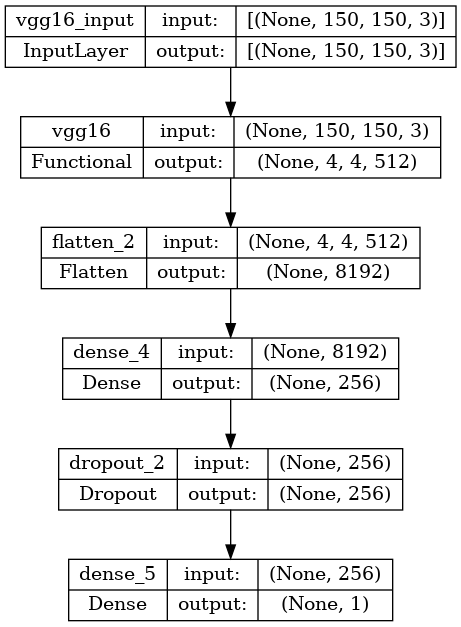

In [15]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

### Compile model

In [16]:
model.compile(loss='binary_crossentropy',
              metrics=['acc'],
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5))

### Fit Model

In [17]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data= validation_generator,
    validation_steps=50
)

Epoch 1/30


/tmp/ipykernel_1743640/3385942099.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2023-04-18 20:10:39.067499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 0.5277 - acc: 0.7315

2023-04-18 20:11:45.591303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 79s 779ms/step - loss: 0.5277 - acc: 0.7315 - val_loss: 0.2872 - val_acc: 0.8860
Epoch 2/30
100/100 [==============================] - 72s 721ms/step - loss: 0.3121 - acc: 0.8680 - val_loss: 0.1543 - val_acc: 0.9380
Epoch 3/30
100/100 [==============================] - 73s 727ms/step - loss: 0.2530 - acc: 0.8955 - val_loss: 0.1263 - val_acc: 0.9420
Epoch 4/30
100/100 [==============================] - 73s 728ms/step - loss: 0.2084 - acc: 0.9185 - val_loss: 0.2948 - val_acc: 0.8870
Epoch 5/30
100/100 [==============================] - 73s 726ms/step - loss: 0.1644 - acc: 0.9360 - val_loss: 0.1611 - val_acc: 0.9350
Epoch 6/30
100/100 [==============================] - 72s 722ms/step - loss: 0.1485 - acc: 0.9450 - val_loss: 0.1053 - val_acc: 0.9650
Epoch 7/30
100/100 [==============================] - 72s 724ms/step - loss: 0.1333 - acc: 0.9465 - val_loss: 0.1137 - val_acc: 0.9570
Epoch 8/30
100/100 [==============================] - 72s 721ms/st

### Fine_Tune

In [18]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


### Compile model

In [19]:
model.compile(loss='binary_crossentropy',
              metrics=['acc'],
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5))

### Fit Model

In [20]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data= validation_generator,
    validation_steps=50
)

Epoch 1/30


/tmp/ipykernel_1743640/3385942099.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2023-04-18 20:46:56.180797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 0.0137 - acc: 0.9950

2023-04-18 20:47:28.230924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 45s 444ms/step - loss: 0.0137 - acc: 0.9950 - val_loss: 0.1260 - val_acc: 0.9660
Epoch 2/30
100/100 [==============================] - 44s 443ms/step - loss: 0.0162 - acc: 0.9930 - val_loss: 0.1109 - val_acc: 0.9710
Epoch 3/30
100/100 [==============================] - 44s 440ms/step - loss: 0.0153 - acc: 0.9955 - val_loss: 0.1195 - val_acc: 0.9730
Epoch 4/30
100/100 [==============================] - 44s 441ms/step - loss: 0.0111 - acc: 0.9955 - val_loss: 0.1857 - val_acc: 0.9710
Epoch 5/30
100/100 [==============================] - 44s 441ms/step - loss: 0.0168 - acc: 0.9950 - val_loss: 0.1465 - val_acc: 0.9710
Epoch 6/30
100/100 [==============================] - 44s 441ms/step - loss: 0.0170 - acc: 0.9955 - val_loss: 0.1391 - val_acc: 0.9700
Epoch 7/30
100/100 [==============================] - 44s 441ms/step - loss: 0.0073 - acc: 0.9980 - val_loss: 0.1627 - val_acc: 0.9700
Epoch 8/30
100/100 [==============================] - 44s 440ms/st

### Save model

In [21]:
model.save('cats_and_dogs_pretrained_with_fine_tuning.h5')